# TD Régression

## Régression linéaire pour la détection précoce d'épidémies via les données de requête sur un moteur de recherche

Les épidémies de [grippe](https://fr.wikipedia.org/wiki/Grippe) ([influenza](https://en.wikipedia.org/wiki/Influenza)) constituent un problème de santé publique majeur, avec problèmes respiratoires, fièvre, hospitalisations, décès...
Les *Centers for Disease Control and Prevention* (CDC) américains et le  *European Influenza Surveillance Scheme* (EISS) détectent l'activité de la grippe via un réseau de surveillance virologique et clinique, dont le nombre *Influenza-like Illness* `ILI` de visites liées à la grippe chez le médecin. 
Le problème considéré ici est la détection précoce de l'épidémie via l'examen des [requêtes sur un moteur de recherche](https://www.google.org/flutrends/) liées aux symptomes et à l'information sur la maladie. 



 Le problème va ici être traité avec des données américaines, mais les données européennes et françaises sont disponibles très facilement ([ici](http://ecdc.europa.eu/en/data-tools/Pages/home.aspx) et [là](https://www.google.org/flutrends/fr/#FR)). 

- ILI Data - The CDC publishes on its website the official regional and state-level percentage of patient visits to healthcare providers for ILI purposes on a weekly basis.

- Google Search Queries - Google Trends allows public retrieval of weekly counts for every query searched by users around the world. For each location, the counts are normalized by dividing the count for each query in a particular week by the total number of online search queries submitted in that location during the week. Then, the values are adjusted to be between 0 and 1.

Le fichier csv `FluTrain.csv` aggrège les données ILI et les requêtes Google entre le 1er janvier 2004 et le 31 décembre 2011. Le fichier comporte alors les colonnes suivantes :

- "Week" - The range of dates represented by this observation, in year/month/day format.

- "ILI" - This column lists the percentage of ILI-related physician visits for the corresponding week.

- "Queries" - This column lists the fraction of queries that are ILI-related for the corresponding week, adjusted to be between 0 and 1 (higher values correspond to more ILI-related search queries).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib notebook

### Question 1 : récupération des données - premières observations

**À faire :** A l'aide du module **`pandas`**, chargez le fichier csv `FluTrain.csv`, sous le nom `fluTrain`, en utilisant la méthode pd.read_csv. 

In [2]:
fluTrain = pd.read_csv("FluTrain.csv")

Avant d'appliquer quelque méthode que ce soit, on va s'intéresser un peu aux données elles-même.

**À faire :** Affichez les 10 premieres lignes des données.

**Conseil :** Souvenez vous que [`df.loc[]`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.loc.html#pandas.DataFrame.loc) permet d'adresser les lignes d'un dataframe df, et que pour accéder à un élément, il faut faire [`df[colonne][ligne]`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html).

In [3]:
fluTrain.loc[:10]

,Week,ILI,Queries
0,2004-01-04 - 2004-01-10,2.418331,0.237716
1,2004-01-11 - 2004-01-17,1.809056,0.220452
2,2004-01-18 - 2004-01-24,1.712024,0.225764
3,2004-01-25 - 2004-01-31,1.542495,0.237716
4,2004-02-01 - 2004-02-07,1.437868,0.224436
5,2004-02-08 - 2004-02-14,1.324274,0.207171
6,2004-02-15 - 2004-02-21,1.307257,0.241700
7,2004-02-22 - 2004-02-28,1.036977,0.216467
8,2004-02-29 - 2004-03-06,1.010320,0.225764
9,2004-03-07 - 2004-03-13,1.052492,0.199203


**À faire :** Affichez la description par respectivement `fluTrain.describe()`.

In [4]:
fluTrain.describe()

,ILI,Queries
count,417.000000,417.000000
mean,1.676861,0.286028
std,1.126163,0.157697
min,0.534093,0.041169
25%,0.902459,0.156707
50%,1.252563,0.281541
75%,2.058690,0.378486
max,7.618892,1.000000


En considérant la période de 2004 à 2011 (exclu),

**À faire :** Tracez sur le même graphique l'évolution des indices ILI et Queries au cours des semaines.

**Conseil :** Regardez la documentation de [`matplotlib.pyplot.plot`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) et pensez à normaliser les valeurs de la colonne ILI pour que la valeur maximum soit égale à 1 lors de l'affichage.

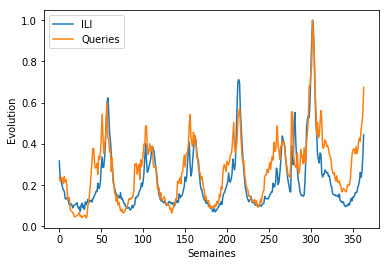

In [7]:
plt.plot(fluTrain[:364]['ILI']/fluTrain[:364]['ILI'].max(), label="ILI")
plt.plot(fluTrain[:364]['Queries'], label="Queries")
plt.xlabel('Semaines')
plt.ylabel('Evolution')
plt.legend()

**Questions :**
- Que constatez-vous ? 
- Observez-vous un motif périodique ?
   - Si oui, quel est sa période et selon vous quel en est la cause ?
- Observez-vous que l'une des courbes semble évoluée en avances par rapport à l'autre ?
   - Si oui, selon vous quel en est la cause ?
- À partir de ces observations,
   - Pensez-vous qu’il est possible d’introduire d’autres informatiques que `Queries` pour obtenir une meilleur prédiction de l’`ILI` ? Si oui, les quelles ?
   - Pensez-vous que prendre uniquement la valeur courante de `Queries` pour prédire l’`ILI` est suffisant ?

**Vos réponses :**


On constate en premier lieu que les deux courbes présentent une certaine similarité ainsi qu'une indéniable périodicité annuelle. On peut émettre l'hypothèse raisonnable que celle-ci occure lors d'épisodes épidémiques d'infections de type Influenza, durant l'hiver.
On peut de plus remarquer que la courbe des requêtes (*Queries*) a une légère avance sur celle des détections avérées. On peut supposer que les personnes touchées par ces infections vont comparer leurs symptômes en ligne avant de consulter leur médecin traitant.  

On pourrait éventuellement s'intéresser à la variable temporelle (semaine contre semaine ou saison contre saison)

### Question 2 : examen de la variable ILI, nuage de points Queries-ILI

Considérons maintenant les données plus globalement. 

**À faire :** Tracez un histogramme de la variable explicative ILI.

**Conseil :** Regardez la documentation de [`matplotlib.pyplot.hist()`](https://matplotlib.org/gallery/statistics/hist.html).

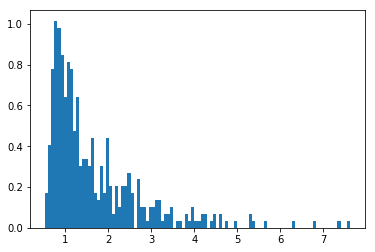

In [9]:
plt.hist(fluTrain['ILI'],100, density=True);

**Questions :**
- La distribution est-elle asymétrique, symétrique ? 
- Présente-t-elle des événements rares (la queue de la distribution est relativement "élevée" comparativement à une exponentielle ou gaussienne) ?

**Vos réponses :**

Distribution asymétrique et éléments rares

**À faire :** Tracer le nuage de points avec la variable Queries en abscisses et la variable ILI en ordonnée.

**Conseil :** Regardez la documentation de [`matplotlib.pyplot.scatter()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.scatter.html#matplotlib.pyplot.scatter).

Text(0, 0.5, 'ILI')

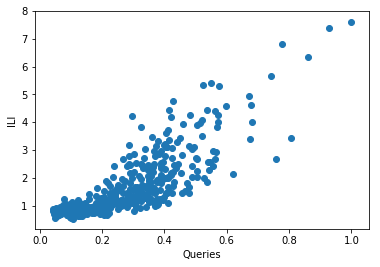

In [10]:
plt.scatter(fluTrain['Queries'], fluTrain['ILI'])
plt.xlabel('Queries')
plt.ylabel('ILI')

**Questions :** Ce nuage indique t-il un lien linéaire entre les 2 variables disponibles ?

**Vos réponses :**

Ce nuage semble indiquer un certain lien, bien que non-linéaire, entre ces deux variables

### Question 3 Nuage de points Queries - log(ILI)

**À faire :** Ajoutez à `fluTrain` une colonne `'log_ILI'` qui contient le logarithme de la colonne `'ILI'`

**Conseil :** Regardez la documentation de [`pandas.DataFrame.apply()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.apply.html) et de [`numpy.log()`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.log.html).

In [11]:
fluTrain['log_ILI'] = fluTrain['ILI'].apply(np.log)

**À faire** : Tracer le nuage de points du logarithme de ILI en fonction de la variable Queries.

Text(0, 0.5, 'log(ILI)')

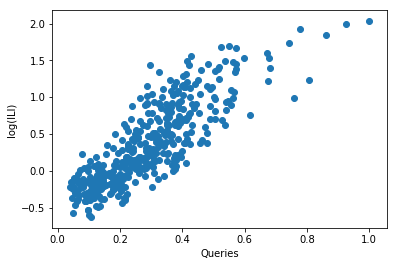

In [12]:
plt.scatter(fluTrain['Queries'], fluTrain['log_ILI'])
plt.xlabel('Queries')
plt.ylabel('log(ILI)')

**Questions :** 
- Qu'est-ce que ce tracé suggère ?
- Une relation linéaire entre log(ILI) et Queries ? Si oui, cette relation est elle, positive ou négative ?

**Vos réponses :**

Ce tracé suggère une relation positive entre les deux grandeurs.



**À faire** : Calculez la corrélation entre ces deux variables.

**Conseil :** Regardez la documentation de [`numpy.corrcoef()`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.corrcoef.html)

In [13]:
np.corrcoef(fluTrain['log_ILI'],fluTrain['Queries'])[0,1]

0.8420332863659171

### Question 4 : Régression linéaire de log(ILI) par rapport à Queries (prédire le nb de visites en fct du nb de requêtes sur internet.

**À faire** : Effectuer une régression linéaire entre log(ILI) et Queries.

**Conseil :** Regardez la documentation de [`sklearn.linear_model.LinearRegression()`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)

In [14]:
from sklearn import linear_model

regr = linear_model.LinearRegression()
regr.fit(fluTrain[['Queries']], fluTrain['log_ILI']);

**Questions :** Quels sont les coefficients obtenus ?

In [16]:
b0=regr.intercept_
b1=regr.coef_[0]
print('b0 = %.2f, b1 = %.2f'%(b0, b1))

b0 = -0.50, b1 = 2.96


**Questions :** 
- Quel est le score R2 ?
- La prédiction est elle efficace (explique t-elle la variance de la variable logILI ?)

In [17]:
R2=regr.score(fluTrain[['Queries']], fluTrain['log_ILI'])
print('R2 = %.2f'%(R2, ))

R2 = 0.71


**Vos réponses :**

La prédiction semble plutôt efficace, bien qu'elle ne soit pas optimale.

**À faire** : Tracer le nuage de points et la droite de régresssion. 

Text(0, 0.5, 'log(ILI)')

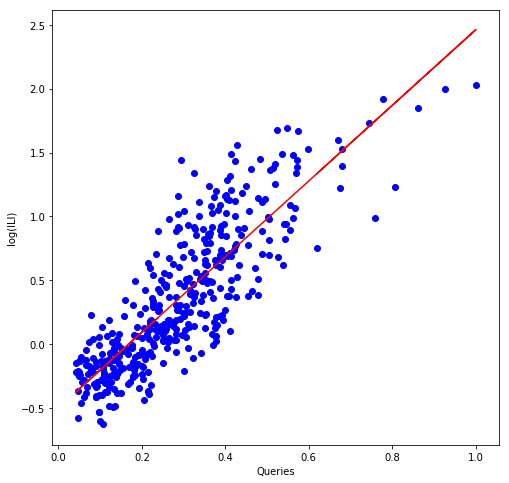

In [18]:
plt.figure(figsize=(8, 8))
plt.scatter(fluTrain[['Queries']], fluTrain['log_ILI'],c='b')
log_ILI_pred_Train=regr.predict(fluTrain[['Queries']])
plt.plot(fluTrain[['Queries']],log_ILI_pred_Train,c='r')
plt.xlabel('Queries')
plt.ylabel('log(ILI)')

**Questions :** Quel est l'accroissement moyen du nombre de visites pour un accroissement de 10 % des requêtes sur internet liées à la grippe?

**Vos réponses :**

Celui-ci est de d'environ 1.34 (exp(n1\*0.1)).

### Question 5: Performances de cette régression sur une base de test (les données de l' année suivante) 

Le fichier csv `FluTest.csv` contient les données pour l'année 2012. 

**À faire :** 
- Chargez ces données dans un dataframe `fluTest`.
- Ajoutez à `fluTest` une colonne `'log_ILI'` qui contient le logarithme de la colonne `'ILI'`
- Calculez l'ensemble des prédictions de ILI pour la variable `Queries` de la base de test.

**Conseil :**  Prenez garde au fait que le modèle vous permet de prédire le **log** de ILI, et vous devez donc au passage prendre quelque part une exponentielle.

In [20]:
fluTest=pd.read_csv('FluTest.csv')
fluTest['log_ILI'] = fluTest['ILI'].apply(np.log)
ILI_pred_Test = np.exp(regr.predict(fluTest[['Queries']]))

**À faire :** Tracer le nuage de points et la courbe de régresssion.

Text(0, 0.5, 'ILI')

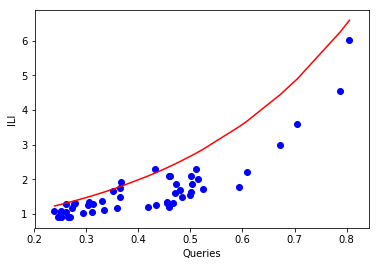

In [21]:
idx = fluTest['Queries'].argsort()
plt.scatter(fluTest[['Queries']], fluTest['ILI'],c='b')
plt.plot(fluTest['Queries'][idx],ILI_pred_Test[idx],c='r')
plt.xlabel('Queries')
plt.ylabel('ILI')

**Questions :** 
- Quelle est votre estimée pour le nombre de visites chez le médecin liées à la grippe, pour la semaine du 11 mars 2012 ?
- Quelle était la vraie valeur de ce nombre ?

In [22]:
print('Nb Visites semaine du 11 mars 2012: %.2f'%ILI_pred_Test[10])
print('Nombre réel de visites le 11 mars 2012: %.2f'%fluTest['ILI'][10]) 

Nb Visites semaine du 11 mars 2012: 2.19
Nombre réel de visites le 11 mars 2012: 2.29


**Questions :** Quels sont les RSS et RSE sur la base de test?

In [23]:
RSS=np.sum((fluTest['ILI'] - ILI_pred_Test)**2)
N=len(fluTest['ILI'])
RSE=np.sqrt(RSS/(N-2))
print('RSS = %.2f, RSE =%.2f'%(RSS,RSE))

RSS = 29.18, RSE =0.76


### Question 6 : Régression linéaire multiple

Pour améliorer le modèle, on pourra chercher à prévoir logILI, le logarithme du nombre de visites chez le médecin, non seulement en fonction des Queries courantes mais aussi des Queries des semaines précédentes et des enregistrements du nombre de visites les semaines précédentes. Du fait des délais de transmission, on ne dispose en général pas des nombres de visites la semaine précédente mais seulement de celles avec un retard de 2 semaines et au-delà.

**À faire :** Ajoutez à `fluTrain` et `fluTest` les colonnes `'log_ILI2'` et `'log_ILI3'` qui correspondent aux nombres de visites les 2e et 3e semaines précédentes, ainsi que les colonnes `'Queries1'`, `'Queries2'` pour les deux semaines précédentes.

**Conseil :** Regardez la documentation de [`pandas.DataFrame.shift()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shift.html)

In [24]:
fluTrain['log_ILI2'] = fluTrain['log_ILI'].shift(periods=2)
fluTrain['log_ILI3'] = fluTrain['log_ILI'].shift(periods=3)
fluTrain['Queries1'] = fluTrain['Queries'].shift(periods=1)
fluTrain['Queries2'] = fluTrain['Queries'].shift(periods=2)

fluTest['log_ILI2'] = fluTest['log_ILI'].shift(periods=2)
fluTest['log_ILI3'] = fluTest['log_ILI'].shift(periods=3)
fluTest['Queries1'] = fluTest['Queries'].shift(periods=1)
fluTest['Queries2'] = fluTest['Queries'].shift(periods=2)

**À faire :** Tracer les nuages de points pour déterminer les variables à priori liées à logILI que l'on veut prédire

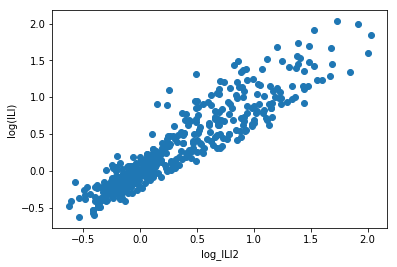

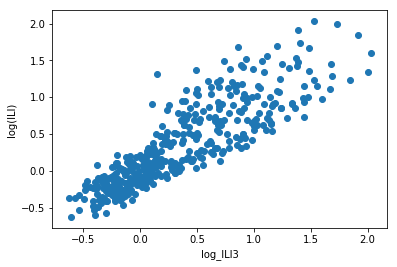

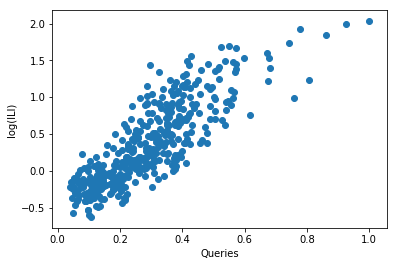

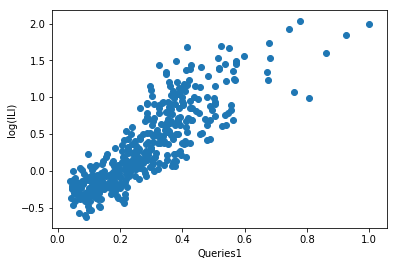

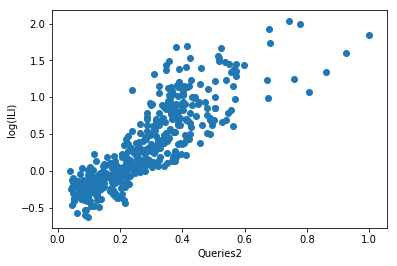

In [28]:
features = ['log_ILI2', 'log_ILI3', 'Queries', 'Queries1', 'Queries2']

for feature in features:
    plt.figure()
    plt.scatter(fluTrain[feature], fluTrain['log_ILI'])
    plt.xlabel(feature)
    plt.ylabel('log(ILI)')

**À faire :** Calculez la matrice de cocorrélation et faire le lien avec les observations précédentes.

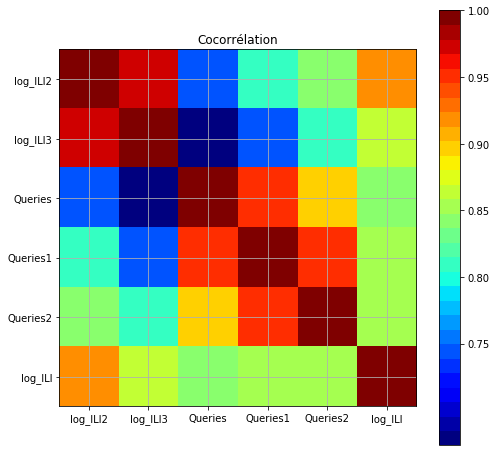

In [29]:
def correlation_matrix(df):

    fig = plt.figure(figsize=(8, 8))
    ax1 = fig.add_subplot(111)
    cmap = cm.get_cmap('jet', 30)
    cax = ax1.imshow(df.corr(), interpolation="nearest", cmap=cmap)
    ax1.grid(True)
    plt.title('Cocorrélation')
    labels=['',]+list(df.columns)
    ax1.set_xticklabels(labels,fontsize=10)
    ax1.set_yticklabels(labels,fontsize=10)
    # Add colorbar, make sure to specify tick locations to match desired ticklabels
    fig.colorbar(cax, ticks=[.75,.8,.85,.90,.95,1])
    plt.show()

correlation_matrix(fluTrain[features+['log_ILI']])

**À faire :** Mettre en oeuvre une régression qui permette de prédire `log_ILI` en fonction du `Queries` actuelle et des variables explicatives des semaines passées.

In [30]:
regr.fit(fluTrain[features][3:], fluTrain['log_ILI'][3:]);

**À faire :** Donner les RSS et RSE sur la base de test, commentez.

In [31]:
ILI_pred_Test_2 = np.exp(regr.predict(fluTest[features][3:]))

RSS=np.sum((fluTest['ILI'][3:] - ILI_pred_Test_2)**2)
N=len(fluTest['ILI'][3:])
RSE=np.sqrt(RSS/(N-2))
print('RSS = %.2f, RSE =%.2f'%(RSS,RSE))

RSS = 3.11, RSE =0.26


## Régression par plus proches voisins

Nous allons mettre en oeuvre la technique des plus proches voisins pour essayer de prédire le nombre de visites à partir des variables explicatives vues précédemment  nombre de requêtes 

### Question 7 : PPV  avec une seule variable explicative

**À faire :** Reprendre la fonction reg_knn_1D du cours pour tester les performances de cette régression. (Vous pourrez modifier les valeurs du nombre de PPV testées).


In [32]:
from sklearn import neighbors

def reg_knn_1D(x_train, y_train, x_test, y_test, k):
    plt.figure(figsize=(8, 8))
    knn = neighbors.KNeighborsRegressor(k, weights='uniform')
    knn.fit(x_train, y_train)
    yppv=knn.predict(x_test)
    S=knn.score(x_test, y_test)
    plt.scatter(x_train, y_train, c='r')
    plt.scatter(x_test,y_test, c='b')
    idx = x_test[x_test.columns[0]].argsort()
    plt.plot(x_test[x_test.columns[0]][idx], yppv[idx], c='g',linewidth=2, label=('PPV K=%d, score= %.2f'%(k,S)))
    plt.legend(fontsize=15)

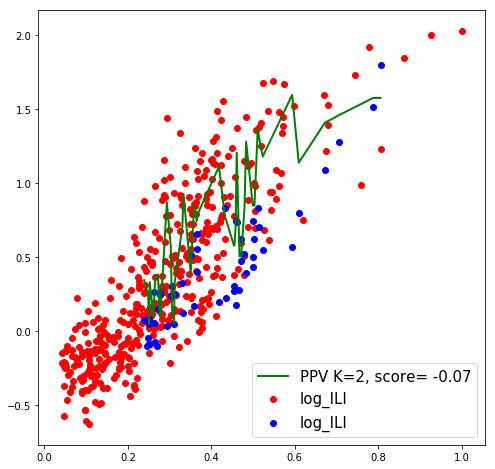

In [49]:
reg_knn_1D(fluTrain[['Queries']], fluTrain['log_ILI'], fluTest[['Queries']], fluTest['log_ILI'], 2)

### Question 8 : PPV avec toutes les variables explicatives

**À faire :** Reprendre les variables utilisées pour la régression linéaire multiple et tester la régression par la méthode des k-PPV (Vous pourrez modifier les valeurs du nombre de PPV testées).

In [47]:
k = 2
knn = neighbors.KNeighborsRegressor(k, weights='uniform')
knn.fit(fluTrain[features][3:], fluTrain['log_ILI'][3:])
S=knn.score(fluTest[features][3:], fluTest['log_ILI'][3:])

print('Pour K= %.2f,score= %.2f'%(k,S))

ILI_pred_Test_2 = np.exp(knn.predict(fluTest[features][3:]))

RSS=np.sum((fluTest['ILI'][3:] - ILI_pred_Test_2)**2)
N=len(fluTest['ILI'][3:])
RSE=np.sqrt(RSS/(N-2))
print('RSS = %.2f, RSE =%.2f'%(RSS,RSE))

Pour K= 2.00,score= 0.76
RSS = 16.56, RSE =0.59


### Question 9 : Choix automatique du nombre de voisins

Nous voulons effectuer la recherche du nombre de voisins optimal (qui obtient la meilleure performance) de manière automatique. Pour cela, nous allons simplement tester un grand nombre de valeur pour k (par exemple entre 1 et 50) et choisir la valeur de k qui obtient la  meilleure performance. Mais la question qu’il se pose est sûr quel ensembles devons-nous effectuer la mesure de performance ?

En effet, si nous choisissons la valeur de k qui obtient la meilleure performance sur l’ensemble d’entrainement, il y a de très fortes chances que cette valeur de k entraine un sur-apprentissage (appris par cœur) de l’ensemble d’entrainement.
Et si nous choisissons la valeur de k qui obtient la meilleure performance sur l’ensemble de test, nous ne pouvons plus garantir que notre apprentissage offre une bonne généralisation.

Il nous faut alors un 3eme ensemble pour tester la performance de notre algorithme de régression en fonction du paramètre k. cette ensemble s’appelle l’ensemble de **validation** et il est obtenu en découpant d’ensemble d’entrainement.

**À faire :** Découpez l'ensemble d'entraimenent `fluTrain` en deux ensemble `fluTrain2` et `fluVal`.

**Conseil :** Regardez la documentation de [`sklearn.model_selection.train_test_split()`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

In [36]:
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split

In [37]:
fluTrain2, fluVal = train_test_split(fluTrain[3:])

**À faire :** Testez pour des valeurs de k entre 1 et 50 la performance obtenue avec le score RSE sur l'ensemble de `fluVal` (avec l'apprentissage sur `fluTrain2`).

Text(0, 0.5, 'RSE')

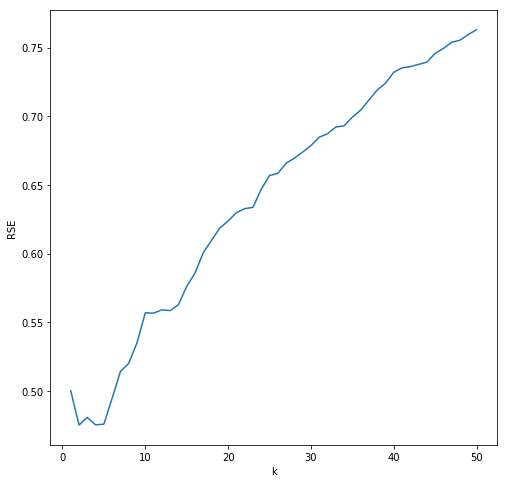

In [38]:
ks = np.arange(1,51)
RSEs = np.zeros(ks.shape)
for i in range(ks.shape[0]):
    k = ks[i]
    knn = neighbors.KNeighborsRegressor(k, weights='uniform')
    knn.fit(fluTrain2[features], fluTrain2['log_ILI'])

    ILI_pred_Val = np.exp(knn.predict(fluVal[features]))

    RSS=np.sum((fluVal['ILI'] - ILI_pred_Val)**2)
    N=len(fluVal['ILI'])
    RSEs[i]=np.sqrt(RSS/(N-2))
    
plt.figure(figsize=(8, 8))
plt.plot(ks, RSEs)
plt.xlabel('k')
plt.ylabel('RSE')

**Questions : **
- Pour quelle valeur de k, le RSE est-il minimum ?
- Si vous utilisez cette valeur de k dans la question précédente, avez-vous une meilleure performance que la régression linéaire ?

In [39]:
print("Le meilleur k est", ks[np.argmin(RSEs)])

Le meilleur k est 2


**Vos réponses :**




    